In [1]:
import pandas as pd
import numpy as np
from numpy import savetxt
from tqdm import tqdm, tqdm_notebook
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', None)
import itertools

In [2]:
import econml
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Main imports
from econml.ortho_forest import DMLOrthoForest, DROrthoForest
from econml.causal_tree import CausalTree
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso, WeightedLassoCV

from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter
import graphviz

# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
import matplotlib.pyplot as plt

%matplotlib inline

# A few more imports
import os
import pandas as pd
import urllib.request
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [4]:
case_id_col = "Case ID"
activity_col = "Activity"
resource_col = "org:resource"
timestamp_col = "time:timestamp"

treatment = 'treatment'
outcome = 'duration'

In [5]:
dynamic_cat_cols = ["Activity", 'org:resource', 'Action', 'EventOrigin', 'lifecycle:transition']
static_cat_cols = ['ApplicationType', 'LoanGoal']
dynamic_num_cols = ['FirstWithdrawalAmount', 'MonthlyCost', 'NumberOfTerms', 'OfferedAmount', "open_cases", "month", "weekday", "hour"]
static_num_cols = ['RequestedAmount', 'CreditScore', 'timesincefirstcase', 'duration', 'treatment']

In [6]:
tqdm.pandas()

In [7]:
def read_data(file):
    #df = pd.read_csv(file,sep=';')
    df = pd.read_csv(file,sep=';',compression="zip")
    return df


def prep_data(df):
    
    
    # CreditScore handling
    df.CreditScore.replace(0.0,np.nan, inplace=True) 
    df['CreditScore'].fillna((df['CreditScore'].median()), inplace=True)
    
    # MonthlyCost handling
    df.MonthlyCost.replace(0.0,np.nan, inplace=True) 
    df['MonthlyCost'].fillna((df['MonthlyCost'].median()), inplace=True)
    
    # NumberOfTerms handling
    df.NumberOfTerms.replace(0.0,np.nan, inplace=True) 
    df['NumberOfTerms'].fillna((df['NumberOfTerms'].median()), inplace=True)
    
    # FirstWithdrawalAmount handling
    df.FirstWithdrawalAmount.replace(0.0,np.nan, inplace=True) 
    df['FirstWithdrawalAmount'].fillna((df['FirstWithdrawalAmount'].median()), inplace=True)
    
    
    # for FrequencyOfIncompleteness
    df2 = df[df['Activity']=='A_Incomplete']
    df_new = pd.DataFrame(df2.groupby(['Case ID'])['Activity'].count()).reset_index()
    df_new.columns = ['Case ID', 'FreqOfIncompleteness']
    df_new = pd.DataFrame(df_new.groupby('Case ID')['FreqOfIncompleteness'].sum()).reset_index()
    df = pd.merge(df_new, df, on='Case ID', how = 'outer')
    df['FreqOfIncompleteness'].fillna(0, inplace=True)
    
    # For NumberOfOffers
    df2 = df[df['Activity'] == "O_Created"] # to count offers
    df_new = pd.DataFrame(df2.groupby(['Case ID'])['Activity'].count()).reset_index()
    df_new.columns = ['Case ID', 'NumberOfOffers']
    df = pd.merge(df_new, df, on='Case ID', how = 'outer')
    
    df = get_case_starttime(df)
    
    return df

In [8]:
import time
import datetime
from datetime import timezone, timedelta
    
def get_duration(group):
    group = group.sort_values(timestamp_col, ascending=True, kind='mergesort')
    group['nr_event'] = range(len(group),0,-1)
    group['duration'] = group[timestamp_col].iloc[-1] - group[timestamp_col].iloc[0]
    group["duration"] = group["duration"] / np.timedelta64(1, 'D')
    
    return group

In [9]:
# function to get the discrete treatment
def get_treatment(activity, df):
    df['treatment'] = 0
    df2 = df[df[activity_col] == activity]
    case_ids = list(set(df2[case_id_col]))
    print(len(case_ids))
    df.loc[df[case_id_col].isin(case_ids),"treatment"] = 1
        
    
    return df

In [10]:
def keep_first(group):
    return group.head(1)

# function to get the continuous treatment
def get_activity_time(activity, df):
    df2 = df[df['Activity'] == activity]
    df2 = df2.groupby('Case ID').apply(keep_first)
    
    df_new = pd.DataFrame(df2[['Case ID', 'timesincecasestart']])
    df_new.reset_index(drop=True, inplace=True)
    #df_new.rename(columns = {'timesincecasestart':'time_of_'+activity}, inplace = True)
    df_new.rename(columns = {'timesincecasestart':'treatment'}, inplace = True)
    df_new['treatment'] = df_new['treatment']/1440
    
    df3 = pd.merge(df_new, df, on='Case ID', how = 'outer')
    df3 = df3.dropna(subset=['treatment'])
    
    return df3

In [11]:
def get_case_starttime(df):
    group = df[df["event_nr"]==1]
    group = group.sort_values(timestamp_col, ascending=False, kind='mergesort')
    
    tmp = group[timestamp_col] - group[timestamp_col].iloc[-1]
    tmp = tmp.fillna(pd.Timedelta(seconds=0))
    group['timesincefirstcase'] = tmp.apply(lambda x: float(x / np.timedelta64(1, 'D'))) # D is for days
    group = pd.DataFrame(group[[case_id_col, 'timesincefirstcase']])
    
    group = pd.merge(group, df, on='Case ID', how = 'outer')
    
    return group

In [12]:
data = 'BPIC17_O_Accepted.zip'
df = read_data(data)

In [14]:
df[timestamp_col] = pd.to_datetime(df[timestamp_col])
df = df.groupby(case_id_col).progress_apply(get_duration)
df = df.reset_index(drop=True)

100%|██████████| 31413/31413 [01:37<00:00, 323.04it/s]


In [15]:
df = prep_data(df)

In [16]:
activity = 'W_Call incomplete files'
df = get_treatment(activity, df)

14958


In [17]:
end_activity = [activity]
end_points = []
def cut_between_activities(group):
    end_activity_idxs = np.where(group[activity_col].isin(end_activity))[0]
    if len(end_activity_idxs) > 0:
        cut_idx_end = end_activity_idxs[0]
        end_points.append(cut_idx_end)
    else:

        cut_idx_end = int(np.random.choice(list(range(min(end_points), max(end_points))), 1))
        if group[group["nr_event"]==1].iloc[0]["event_nr"] <= cut_idx_end:
            cut_idx_end = min(end_points)
    
    return group[:cut_idx_end]

In [18]:
# get prefixes for discreate treatment 
treated = df[df[treatment]==1]
control = df[df[treatment]==0]
dt_train_prefixes_t = treated.groupby(case_id_col).progress_apply(cut_between_activities)
dt_train_prefixes_c = control.groupby(case_id_col).progress_apply(cut_between_activities)

dt_prefixes = pd.concat([dt_train_prefixes_c, dt_train_prefixes_t], axis=0).reset_index(drop=True)

100%|██████████| 16455/16455 [01:03<00:00, 259.33it/s]


In [19]:
import EncoderFactory

agg_encoder = EncoderFactory.get_encoder("agg", case_id_col=case_id_col, static_cat_cols=static_cat_cols,
                                         static_num_cols=static_num_cols, dynamic_cat_cols=dynamic_cat_cols,
                                         dynamic_num_cols=[])
last_encoder = EncoderFactory.get_encoder("last", case_id_col=case_id_col, static_cat_cols=static_cat_cols,
                                         static_num_cols=static_num_cols, dynamic_cat_cols=[],
                                         dynamic_num_cols=dynamic_num_cols)

In [20]:
agg_encoded = agg_encoder.fit_transform(dt_prefixes)
last_encoded = last_encoder.fit_transform(dt_prefixes)

df_encoded = pd.merge(agg_encoded, last_encoded, on='Case ID')

In [21]:
# create data with all features
df_case = df[df["nr_event"]==1]
df2 = df_case[[case_id_col]+static_cat_cols+static_num_cols]

df2 = pd.merge(df2, df_encoded, on='Case ID', how='inner')

In [23]:
df2 = df2.sort_values('timesincefirstcase', ascending=True, kind='mergesort')
df2 = df2.reset_index(drop=True)

In [ ]:
df2.to_csv('data_17_incompleteFiles.csv', index=False)

In [ ]:
df2 = pd.read_csv('data_17_incompleteFiles.csv')

In [33]:
df2['timesincefirstcase'].describe()

count    31413.000000
mean       189.042793
std        101.993112
min          0.000000
25%        101.405038
50%        194.902894
75%        275.356671
max        365.490717
Name: timesincefirstcase, dtype: float64

In [25]:
# Prepare data for time of activity treatment
train, test = train_test_split(df2, test_size=0.2, shuffle=False)
train, valid = train_test_split(train, test_size=0.2, shuffle=False)
features = train.drop([outcome, treatment, case_id_col], axis=1)
features_test = valid.drop([outcome, treatment, case_id_col], axis=1)


cat_confound_cols = ['LoanGoal', 'ApplicationType']
num_confound_cols = features.columns.difference(cat_confound_cols)

cat_hetero_cols = ['LoanGoal', 'ApplicationType']
num_hetero_cols = features.columns.difference(cat_hetero_cols)
#num_hetero_cols = ['RequestedAmount', 'CreditScore']

Y = train[outcome].to_numpy()
T = train[treatment].to_numpy()
scaler = StandardScaler()
W1 = scaler.fit_transform(features[[c for c in num_confound_cols]].to_numpy())
W2 = pd.get_dummies(features[cat_confound_cols]).to_numpy()
W = np.concatenate([W1, W2], axis=1)
X1 = scaler.fit_transform(features[[c for c in num_hetero_cols]].to_numpy())
X2 = pd.get_dummies(features[cat_hetero_cols]).to_numpy()
X = np.concatenate([X1, X2], axis=1)

X1_test = scaler.fit_transform(features_test[[c for c in num_hetero_cols]].to_numpy())
X2_test = pd.get_dummies(features_test[cat_hetero_cols]).to_numpy()
X_test = np.concatenate([X1_test, X2_test], axis=1)

In [27]:
N_trees = [200]
Min_leaf_size = [20]
Max_depth = [30]
Subsample_ratio = [0.4]
Lambda_reg = [0.01]

In [ ]:
# with open("results_1000.csv", "w") as f:
#     f.write("%s, %s, %s, %s, %s, %s\n" % ("n_trees", "min_leaf_size", "max_depth", "subsample_ratio", "lambda_reg", "AUC"))
    
for i in itertools.product(N_trees, Min_leaf_size, Max_depth, Subsample_ratio, Lambda_reg):
    print(i)
    n_trees = i[0]
    min_leaf_size = i[1]
    max_depth = i[2]
    subsample_ratio = i[3]
    lambda_reg = i[4]
    est = DMLOrthoForest(
        n_trees=n_trees, min_leaf_size=min_leaf_size, max_depth=max_depth, 
        subsample_ratio=subsample_ratio, discrete_treatment=True,
        model_T=LogisticRegression(C=1/(X.shape[0]*lambda_reg), penalty='l1', solver='saga'),
        model_Y=Lasso(alpha=lambda_reg),
        model_T_final=LogisticRegression(C=1/(X.shape[0]*lambda_reg), penalty='l1', solver='saga'), 
        model_Y_final=WeightedLasso(alpha=lambda_reg),
        random_state=106
       )
    
    ortho_model = est.fit(Y, T, X, W)
    batches = np.array_split(X_test, X_test.shape[0] / 100)
    treatment_effects = est.const_marginal_effect(batches[0])
    ii = 0
    for batch in batches[1:]:
#         print(ii)
        estimates = est.const_marginal_effect(batch)
        treatment_effects = np.append(treatment_effects, estimates)
        ii += 1
    df_results = valid
    df_results['Treatment Effects'] = treatment_effects
    
    # Calculate default (90%) confidence intervals for the default treatment points T0=0 and T1=1
#     te_lower, te_upper = est.effect_interval(batches[0])
#     ii = 0
#     for batch in batches[1:]:
#         print(ii)
#         lower, upper = est.effect_interval(batch)
#         te_lower = np.append(te_lower, lower)
#         te_upper = np.append(te_upper, upper)
#         ii += 1
        
#     df_results['te_lower'] = te_lower
#     df_results['te_upper'] = te_upper
#     df_results['Interval Length'] = df_results['te_upper'] - df_results['te_lower']
    
    net_value = [0]
    net_value2 = [0]
    net_value3 = [0]

    percentages = [10,20,30,40,50,60,70,80,90,100]

    for n in percentages:
        num = int(len(df_results)*(n/100))
        top_n = df_results.nsmallest(num,'Treatment Effects')
        n_treated = top_n[top_n['treatment']==1].shape[0]
        n_control = top_n[top_n['treatment']==0].shape[0]
        scale_factor = n_treated/n_control

        treated = top_n[top_n['treatment']==1]['duration'].sum()
        control = top_n[top_n['treatment']==0]['duration'].sum()

        reduction = (scale_factor*control) - treated 
        net_value.append(reduction)
        
#     for n in percentages:
#         num = int(len(df_results)*(n/100))
#         top_n = df_results.nsmallest(num,'te_lower')
#         n_treated = top_n[top_n['treatment']==1].shape[0]
#         n_control = top_n[top_n['treatment']==0].shape[0]
#         scale_factor = n_treated/n_control

#         treated = top_n[top_n['treatment']==1]['duration'].sum()
#         control = top_n[top_n['treatment']==0]['duration'].sum()

#         reduction = (scale_factor*control) - treated 
#         net_value2.append(reduction)
        
#     for n in percentages:
#         num = int(len(df_results)*(n/100))
#         top_n = df_results.nsmallest(num,'te_upper')
#         n_treated = top_n[top_n['treatment']==1].shape[0]
#         n_control = top_n[top_n['treatment']==0].shape[0]
#         scale_factor = n_treated/n_control

#         treated = top_n[top_n['treatment']==1]['duration'].sum()
#         control = top_n[top_n['treatment']==0]['duration'].sum()

#         reduction = (scale_factor*control) - treated 
#         net_value3.append(reduction) 
        
#     plt.figure(figsize=(10, 4))
#     plt.subplot(1, 2, 1)
    plt.plot([0]+percentages, net_value, label="'Treatment Effect", marker="o")
#     plt.plot([0]+percentages, net_value2, label="'TE Lower bound", marker="o", color='Green')
#     plt.plot([0]+percentages, net_value3, label="'TE Upper bound", marker="o", color='Red')
    plt.plot([0,percentages[9]], [0,net_value[10]], label="'Random",  marker="o", color='Black',
             linestyle='dashed')
    plt.xlabel('Proportion of cases targeted')
    plt.ylabel('Expected incremental reduction')
    plt.legend(loc='best')
    plt.title(i)

    plt.savefig('Results/_Call_incomplete_files_valid_%s.png'%str(i), format='png', dpi=300)
    
    AUC = np.trapz(net_value, [0]+percentages)
    
#     with open("results_1000.csv", "a") as f:
#         f.write("%s, %s, %s, %s, %s, %s\n" % (n_trees, min_leaf_size, max_depth, subsample_ratio, lambda_reg, AUC))

(200, 20, 30, 0.4, 0.01)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   38.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   37.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   23.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   21.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   22.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   21.

0


[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   22.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


1


[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   22.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


2


[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   22.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


3


[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   22.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


4


[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   21.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


5


[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   21.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


6


[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   22.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


7


[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   22.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


8


[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   23.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


9


[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   22.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


10


[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   22.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


11


[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   23.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


12


[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   21.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


13


[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   24.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


14


[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   22.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


15


[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   22.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


16


[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   22.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


17


[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   25.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


18


[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   23.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


19


[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   23.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


20


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   24.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


21


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   23.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


22


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   24.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


23


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   23.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


24


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   23.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


25


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   24.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


26


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   23.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


27


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   23.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


28


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   23.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


29


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   21.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


30


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   22.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


31


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   23.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


32


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   21.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


33


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   22.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


34


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   22.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


35


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   25.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


36


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   21.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


37


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   22.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


38


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   21.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


39


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   22.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


40


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   22.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


41


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   23.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


42


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   24.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


43


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   22.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


44


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   23.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


45


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   22.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


46


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   23.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


47


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   22.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


48


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   21.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


49


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   22.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


50


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   21.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


51


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   21.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


52


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   21.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


53


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   21.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


54


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   20.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


55


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   20.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


56


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   19.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


57


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   21.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


58


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   20.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


59


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   20.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


60


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   21.1s finished


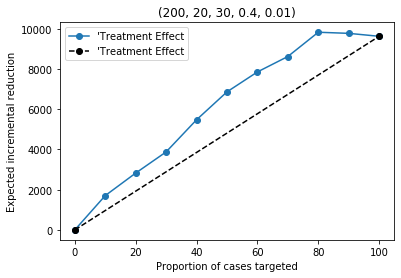

In [28]:
# preparing the test set
f_test = test.drop([outcome, treatment], axis=1)
X1_test = scaler.fit_transform(f_test[[c for c in num_hetero_cols]].to_numpy())
X2_test = pd.get_dummies(f_test[cat_hetero_cols]).to_numpy()
X_test = np.concatenate([X1_test, X2_test], axis=1)


# with open("results_1000.csv", "w") as f:
#     f.write("%s, %s, %s, %s, %s, %s\n" % ("n_trees", "min_leaf_size", "max_depth", "subsample_ratio", "lambda_reg", "AUC"))
    
for i in itertools.product(N_trees, Min_leaf_size, Max_depth, Subsample_ratio, Lambda_reg):
    print(i)
    n_trees = i[0]
    min_leaf_size = i[1]
    max_depth = i[2]
    subsample_ratio = i[3]
    lambda_reg = i[4]
    est = DMLOrthoForest(
        n_trees=n_trees, min_leaf_size=min_leaf_size, max_depth=max_depth, 
        subsample_ratio=subsample_ratio, discrete_treatment=True,
        model_T=LogisticRegression(C=1/(X.shape[0]*lambda_reg), penalty='l1', solver='saga'),
        model_Y=Lasso(alpha=lambda_reg),
        model_T_final=LogisticRegression(C=1/(X.shape[0]*lambda_reg), penalty='l1', solver='saga'), 
        model_Y_final=WeightedLasso(alpha=lambda_reg),
        random_state=106
       )
    
    ortho_model = est.fit(Y, T, X, W)
    batches = np.array_split(X_test, X_test.shape[0] / 100)
    treatment_effects = est.const_marginal_effect(batches[0])
    ii = 0
    for batch in batches[1:]:
#         print(ii)
        estimates = est.const_marginal_effect(batch)
        treatment_effects = np.append(treatment_effects, estimates)
        ii += 1
    df_results = test
    df_results['Treatment Effects'] = treatment_effects
    
    # Calculate default (90%) confidence intervals for the default treatment points T0=0 and T1=1
    te_lower, te_upper = est.effect_interval(batches[0])
    ii = 0
    for batch in batches[1:]:
        print(ii)
        lower, upper = est.effect_interval(batch)
        te_lower = np.append(te_lower, lower)
        te_upper = np.append(te_upper, upper)
        ii += 1
        
    df_results['te_lower'] = te_lower
    df_results['te_upper'] = te_upper
    df_results['Interval Length'] = df_results['te_upper'] - df_results['te_lower']
    
    net_value = [0]
    net_value2 = [0]
    net_value3 = [0]

    percentages = [10,20,30,40,50,60,70,80,90,100]

    for n in percentages:
        num = int(len(df_results)*(n/100))
        top_n = df_results.nsmallest(num,'Treatment Effects')
        n_treated = top_n[top_n['treatment']==1].shape[0]
        n_control = top_n[top_n['treatment']==0].shape[0]
        scale_factor = n_treated/n_control

        treated = top_n[top_n['treatment']==1]['duration'].sum()
        control = top_n[top_n['treatment']==0]['duration'].sum()

        reduction = (scale_factor*control) - treated 
        net_value.append(reduction)
        
#     for n in percentages:
#         num = int(len(df_results)*(n/100))
#         top_n = df_results.nsmallest(num,'te_lower')
#         n_treated = top_n[top_n['treatment']==1].shape[0]
#         n_control = top_n[top_n['treatment']==0].shape[0]
#         scale_factor = n_treated/n_control

#         treated = top_n[top_n['treatment']==1]['duration'].sum()
#         control = top_n[top_n['treatment']==0]['duration'].sum()

#         reduction = (scale_factor*control) - treated 
#         net_value2.append(reduction)
        
#     for n in percentages:
#         num = int(len(df_results)*(n/100))
#         top_n = df_results.nsmallest(num,'te_upper')
#         n_treated = top_n[top_n['treatment']==1].shape[0]
#         n_control = top_n[top_n['treatment']==0].shape[0]
#         scale_factor = n_treated/n_control

#         treated = top_n[top_n['treatment']==1]['duration'].sum()
#         control = top_n[top_n['treatment']==0]['duration'].sum()

#         reduction = (scale_factor*control) - treated 
#         net_value3.append(reduction) 
        
#     plt.figure(figsize=(10, 4))
#     plt.subplot(1, 2, 1)
    plt.plot([0]+percentages, net_value, label="'Treatment Effect", marker="o")
#     plt.plot([0]+percentages, net_value2, label="'TE Lower bound", marker="o", color='Green')
#     plt.plot([0]+percentages, net_value3, label="'TE Upper bound", marker="o", color='Red')
    plt.plot([0,percentages[9]], [0,net_value[10]], label="'Treatment Effect",  marker="o", color='Black',
             linestyle='dashed')
    plt.xlabel('Proportion of cases targeted')
    plt.ylabel('Expected incremental reduction')
    plt.legend(loc='best')
    plt.title(i)

    plt.savefig('Results/_Call_incomplete_files_highD2_%s.png'%str(i), format='png', dpi=300)
    
    AUC = np.trapz(net_value, [0]+percentages)
    
#     with open("results_1000.csv", "a") as f:
#         f.write("%s, %s, %s, %s, %s, %s\n" % (n_trees, min_leaf_size, max_depth, subsample_ratio, lambda_reg, AUC))

In [ ]:
for i in itertools.product(N_trees, Min_leaf_size, Max_depth, Subsample_ratio, Lambda_reg):
    print(i)
    n_trees = i[0]
    min_leaf_size = i[1]
    max_depth = i[2]
    subsample_ratio = i[3]
    lambda_reg = i[4]
    est = DMLOrthoForest(
        n_trees=n_trees, min_leaf_size=min_leaf_size, max_depth=max_depth, 
        subsample_ratio=subsample_ratio, discrete_treatment=True,
        model_T=LogisticRegression(C=1/(X.shape[0]*lambda_reg), penalty='l1', solver='saga'),
        model_Y=Lasso(alpha=lambda_reg),
        model_T_final=LogisticRegression(C=1/(X.shape[0]*lambda_reg), penalty='l1', solver='saga'), 
        model_Y_final=WeightedLasso(alpha=lambda_reg),
        random_state=106
       )
    
    ortho_model = est.fit(Y, T, X, W)

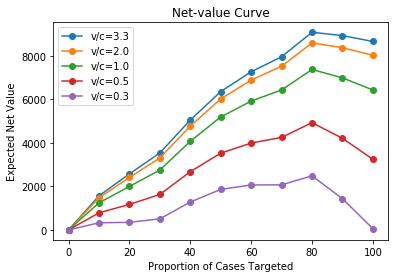

In [29]:
value = [1]
cost = [3,1,2,0.5,0.2]
cost = [0.3,0.5,1,2,3]

percentages = [10,20,30,40,50,60,70,80,90,100]

for i in itertools.product(value, cost):
    net_value = [0]
    v = i[0]
    c = i[1]
    for n in percentages:
        num = int(len(df_results)*(n/100))
        top_n = df_results.nsmallest(num,'Treatment Effects')
        n_treated = top_n[top_n['treatment']==1].shape[0]
        n_control = top_n[top_n['treatment']==0].shape[0]
        scale_factor = n_treated/n_control

        treated = top_n[top_n['treatment']==1]['duration'].sum()
        control = top_n[top_n['treatment']==0]['duration'].sum()

        reduction = (scale_factor*control) - treated
        net_val = (reduction*v) - (n_treated*c) 
        net_value.append(net_val)
    #     net_value.append(reduction)

    # plt.figure(figsize=(10, 4))
    # plt.subplot(1, 2, 1)
    plt.plot([0]+percentages, net_value, label="v/c=%s"%str(round(v/c,1)), marker="o")
#     plt.plot([0,percentages[9]], [0,net_value[10]], label="'Random Policy",  marker="o", color='Gray',
#              linestyle='dashed')
    plt.xlabel('Proportion of Cases Targeted')
    plt.ylabel('Expected Net Value')
    plt.legend(loc='best')
    plt.title('Net-value Curve')

plt.savefig('Results/_Call_incomplete_files_netvals.png', format='png', dpi=300)

In [ ]:
# non cumulative plot
net_value = []
confidence = []


percentages = [10,20,30,40,50,60,70,80,90,100]
num_rows = df_results.shape[0]
df_results = df_results.sort_values('Treatment Effects', ascending=True)

#non cumulative version
for n in percentages:
    top_n = df_results.iloc[round(num_rows * (n-10)/100) : round(num_rows * (n)/100) ,:]
    confidence.append(top_n["Interval Length"].mean()*10)
    n_treated = top_n[top_n['treatment']==1].shape[0]
    n_control = top_n[top_n['treatment']==0].shape[0]
    scale_factor = n_treated/n_control

    treated = top_n[top_n['treatment']==1]['duration'].sum()
    control = top_n[top_n['treatment']==0]['duration'].sum()

    reduction = (scale_factor*control) - treated 
    net_value.append(reduction)
        
# plt.figure(figsize=(10, 4))
# plt.subplot(1, 2, 1)
#plt.plot(percentages, net_value, label="'Treatment Effect", marker="o")
plt.errorbar(percentages, net_value,yerr=confidence, fmt='--o')
# plt.plot([percentages[0],percentages[9]], [net_value[0],net_value[9]], label="'Treatment Effect",  marker="o", color='Black',
#          linestyle='dashed')
plt.title('non cumulative')
# plt.savefig('Results/Change_price_flipped_train_nonCumulative_%s.png'%str(i), format='png', dpi=300)

In [ ]:
# For sensitivity analysis
Y_hat, propensities = est.nuisance_estimator(Y, np.reshape(T, (-1, 1)), X, W)
df_yhat = pd.DataFrame(Y_hat)

df_propensity = pd.DataFrame(propensities)
df_yhat["treatment"] = train.reset_index()["treatment"]

# df_yhat["selected"] = 0
# for i,row in df_yhat.iterrows():
#     df_yhat.loc[i,"selected"] = row[ row["treatment"] ]
    
df_sensitivity = pd.concat([df_propensity[0], df_yhat[0], train.reset_index()[treatment],
                            train.reset_index()[outcome]], keys=['g', 'Q', 't', 'y'], axis = 1)

df_sensitivity.to_csv('Resources.csv', index=False)

In [ ]:
# load results later and compare similarity matrices

df_old = pd.read_csv('BPI17_skip_call_incomplete_withCI.csv')
te = df_old.loc[:,['Treatment Effects']]
df_old = df_results.drop(["duration", "treatment", "Case ID"], axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


cat_hetero_cols = ['LoanGoal', 'ApplicationType']
num_hetero_cols = df_old.columns.difference(cat_hetero_cols)


X1_test = scaler.fit_transform(df_old[[c for c in num_hetero_cols]].to_numpy())
X2_test = pd.get_dummies(df_old[cat_hetero_cols]).to_numpy()
X_test = np.concatenate([X1_test, X2_test], axis=1)

df_old = pd.DataFrame(X_test)

In [ ]:
from scipy.spatial.distance import pdist,squareform

dist_fv = pd.DataFrame(squareform(pdist(df_old)))
dist_te = pd.DataFrame(squareform(pdist(te)))

In [ ]:
import seaborn as sns

sns.heatmap(dist_fv.iloc[:300,:300],cmap="Greens")

In [ ]:
sns.heatmap(dist_te.iloc[:300,:300],cmap="Greens")